In [130]:
!wget https://vision.middlebury.edu/mview/data/data/dinoSparseRing.zip --no-check-certificate

--2020-11-11 18:26:26--  https://vision.middlebury.edu/mview/data/data/dinoSparseRing.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3812923 (3.6M) [application/zip]
Saving to: ‘dinoSparseRing.zip’

dinoSparseRing.zip  100%[===================>]   3.64M   603KB/s    in 10s     

2020-11-11 18:26:38 (361 KB/s) - ‘dinoSparseRing.zip’ saved [3812923/3812923]



In [1]:
import cv2
import numpy as np
from itertools import product

In [2]:
data_dir = "dinoRing/"
file_base = "dinoR"
T = 19

In [149]:
!unzip dinoSparseRing.zip

Archive:  dinoSparseRing.zip
replace dinoSparseRing/dinoSR_ang.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Reading Images and Camera Parameters

In [134]:
# Reading the camera parameters from 'dinoSR_par.txt'
with open(data_dir + "/" + file_base + "_par.txt", 'r') as f:
  lines = f.readlines() 

  M = []
  for l in lines[1:]: 
    tmp = np.array(l.strip().split(" ")[1:]).astype(np.float32)
    K = tmp[0:9].reshape((3, 3))
    R = tmp[9:18].reshape((3, 3))
    t = tmp[18:].reshape((3, 1))
    M.append(np.matmul(K, np.concatenate([R, t], axis=1)))

  N = len(lines) - 1

In [137]:
# Reading images
imgs = []
kernel = np.ones((3,3), np.uint8) 
for i in range(N):
  im = cv2.imread(data_dir + "/" + file_base + f'{i + 1:04}' + ".png", 0) / 255
  im = cv2.erode(im, kernel, iterations=1) 
  im = cv2.dilate(im, kernel, iterations=1) 
  _, im = cv2.threshold(im, 0.1, 1, cv2.THRESH_BINARY)
  print(im)
  imgs.append(np.array(im))
imgs = np.array(imgs)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

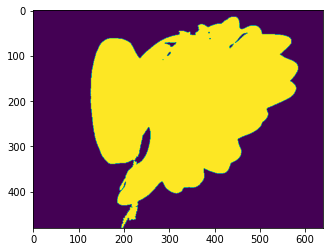

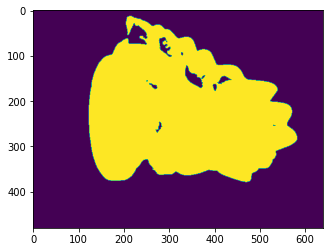

In [138]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(imgs[10])

In [139]:
# Thresholding images for masking
silhouettes = []
for im in imgs:
  silhouettes.append(im > 0)
silhouettes = np.array(silhouettes).transpose(1, 2, 0)

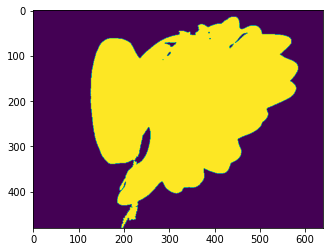

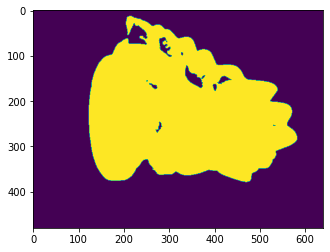

In [140]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(silhouettes[:, :, 0])
plt.figure()
plt.imshow(silhouettes[:, :, 10])

# Visual Hull

In [303]:
# Define a voxel grid which has the 3D locations of each voxel which can then be projected onto each image
def InitializeVoxels(xlim, ylim, zlim, voxel_size):
  voxels_number = [1, 1, 1]
  voxels_number[0] = np.abs(xlim[1]-xlim[0]) / voxel_size[0]
  voxels_number[1] = np.abs(ylim[1]-ylim[0]) / voxel_size[1]
  voxels_number[2] = np.abs(zlim[1]-zlim[0]) / voxel_size[2]
  voxels_number_act = np.array(voxels_number).astype(int) + 1
  total_number = np.prod(voxels_number_act)

  voxel = np.ones((np.int(total_number), 4))

  sx = xlim[0]
  ex = xlim[1]
  sy = ylim[0]
  ey = ylim[1]
  sz = zlim[0]
  ez = zlim[1]

  if(ex > sx):
    x_step = voxel_size[0];
  else:
    x_step = -voxel_size[0];

  if(ey > sy):
    y_step = voxel_size[1];
  else:
    y_step = -voxel_size[1];

  if(ez > sz):
    z_step = voxel_size[2];
  else:
    z_step = -voxel_size[2];

  voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(np.linspace(sx, ex, voxels_number_act[0]), 
                                             np.linspace(sy, ey, voxels_number_act[1]),
                                             np.linspace(sz, ez, voxels_number_act[2]))
  
  l = 0;
  for z in np.linspace(sz, ez, voxels_number_act[2]):
    for x in np.linspace(sx, ex, voxels_number_act[0]):
      for y in np.linspace(sy, ey, voxels_number_act[1]):
        voxel[l] = [x, y, z, 1] 
        l=l+1

  return voxel, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number

In [374]:
voxel_size = [0.001, 0.001, 0.001] # size of each voxel

# The dimension limits
xlim = [0.07, -0.04] # [-0.04, 0.07]
ylim = [0.022, 0.132] # [0.04, 0.15]
zlim = [0.07, -0.04] # [-0.04, 0.07]

voxels, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number = InitializeVoxels(xlim, ylim, zlim, voxel_size);

In [375]:
print(voxels.shape)

(1367631, 4)


In [376]:
print(voxels) # The first three values are the x-y-z-coordinates of the voxel, the fourth value is a dummy variable which we will use later on

[[ 0.07   0.022  0.07   1.   ]
 [ 0.07   0.023  0.07   1.   ]
 [ 0.07   0.024  0.07   1.   ]
 ...
 [-0.04   0.13  -0.04   1.   ]
 [-0.04   0.131 -0.04   1.   ]
 [-0.04   0.132 -0.04   1.   ]]


In [377]:
object_points3D = np.copy(voxels).T
voxels[:, 3] = 0 # making the fourth variable of each voxel 0

proj = []

for i in range(N):

  # CAMERA PARAMETERS
  M_ = M[i]

  # PROJECTION TO THE IMAGE PLANE
  points2D = np.matmul(M_, object_points3D)
  points2D = np.floor(points2D / points2D[2, :]).astype(np.int32)
  points2D[np.where(points2D < 0)] = 0; # check for negative image coordinates

  img_size = (silhouettes).shape
  ind1 = np.where(points2D[1, :] >= img_size[0]) # check for out-of-bounds (width) coordinate
  points2D[:, ind1] = 0
  ind1 = np.where(points2D[0, :] >= img_size[1]) # check for out-of-bounds (height) coordinate
  points2D[:, ind1] = 0

  # ACCUMULATE THE VALUE OF EACH VOXEL IN THE CURRENT IMAGE
  voxels[:, 3] += silhouettes[:, :, i].T[points2D.T[:, 0], points2D.T[:, 1]]

  proj.append(points2D)

In [378]:
print(voxels) # the fourth value is the number of image views (out of N total) which contain this voxel in the object mask

[[ 0.07   0.022  0.07   6.   ]
 [ 0.07   0.023  0.07   6.   ]
 [ 0.07   0.024  0.07   6.   ]
 ...
 [-0.04   0.13  -0.04   0.   ]
 [-0.04   0.131 -0.04   0.   ]
 [-0.04   0.132 -0.04   0.   ]]


In [379]:
def ConvertVoxelList2Voxel3D(voxels_number, voxel_size, voxel):
  sx = -(voxels_number[0] / 2) * voxel_size[0]
  ex = voxels_number[0] / 2 * voxel_size[0]

  sy = -(voxels_number[1] / 2) * voxel_size[1]
  ey = voxels_number[1] / 2 * voxel_size[1]

  sz = -(voxels_number[2] / 2) * voxel_size[2] # 0;
  ez = voxels_number[2] / 2 * voxel_size[2] # voxels_number[2] * voxel_size[2]
  voxels_number = np.array(voxels_number).astype(np.int32)
  voxel3D = np.zeros((voxels_number[1] + 1, voxels_number[0] + 1, voxels_number[2] + 1));

  l = 0
  z1 = 0
  for z in np.arange(sz, ez, voxel_size[2]):
      x1 = 0
      for x in np.arange(sx, ex, voxel_size[0]):
          y1 = 0
          for y in np.arange(sy, ey, voxel_size[1]):
              voxel3D[y1, x1, z1] = voxel[l, 3]
              l = l + 1
              y1 = y1 + 1
          x1 = x1 + 1
      z1 = z1 + 1

  return voxel3D

In [380]:
error_amount = 5
maxv = np.max(voxels[:, 3])
iso_value = maxv-np.round(((maxv)/100)*error_amount)-0.5
print('max number of votes:' + str(maxv))
print('threshold for marching cube:' + str(iso_value))

voxel3D = ConvertVoxelList2Voxel3D(np.array(voxels_number), voxel_size, voxels)

max number of votes:48.0
threshold for marching cube:45.5


In [381]:
# debug
voxel3D[0, :, :] = maxv
# voxel3D[-1, :, :] = maxv

voxel3D[:, 0, :] = maxv
# voxel3D[:, -1, :] = maxv

voxel3D[:, :, 0] = maxv
# voxel3D[:, :, -1] = maxv
print(voxel3D)

[[[48. 48. 48. ... 48. 48. 48.]
  [48. 48. 48. ... 48. 48. 48.]
  [48. 48. 48. ... 48. 48. 48.]
  ...
  [48. 48. 48. ... 48. 48. 48.]
  [48. 48. 48. ... 48. 48. 48.]
  [48. 48. 48. ... 48. 48. 48.]]

 [[48. 48. 48. ... 48. 48. 48.]
  [48.  6.  6. ...  7.  7.  7.]
  [48.  6.  6. ...  7.  7.  7.]
  ...
  [48. 10. 10. ...  5.  5.  5.]
  [48. 10.  9. ...  4.  5.  5.]
  [48. 10.  9. ...  4.  4.  4.]]

 [[48. 48. 48. ... 48. 48. 48.]
  [48.  6.  6. ...  7.  7.  7.]
  [48.  6.  6. ...  7.  7.  7.]
  ...
  [48. 10. 10. ...  5.  5.  5.]
  [48. 10. 10. ...  4.  4.  4.]
  [48. 10.  9. ...  4.  4.  4.]]

 ...

 [[48. 48. 48. ... 48. 48. 48.]
  [48.  0.  0. ...  0.  0.  0.]
  [48.  0.  0. ...  0.  0.  0.]
  ...
  [48.  0.  0. ...  0.  0.  0.]
  [48.  0.  0. ...  0.  0.  0.]
  [48.  0.  0. ...  0.  0.  0.]]

 [[48. 48. 48. ... 48. 48. 48.]
  [48.  0.  0. ...  0.  0.  0.]
  [48.  0.  0. ...  0.  0.  0.]
  ...
  [48.  0.  0. ...  0.  0.  0.]
  [48.  0.  0. ...  0.  0.  0.]
  [48.  0.  0. ...  0.  0.  

# Marching Cubes

In [382]:
# !pip install --upgrade PyMCubes
# !pip install pycollada

In [383]:
import numpy as np
import mcubes

# Extract the 0-isosurface
vertices, triangles = mcubes.marching_cubes(voxel3D, iso_value)

# Export the result to sphere.dae
mcubes.export_mesh(vertices, triangles, "DinoR_21.dae", "DinoR_21_")